## Stage-wise Transcriptomic Analysis in Duchenne Muscular Dystrophy

Duchenne muscular dystrophy (DMD) is a progressive disorder characterized by distinct molecular changes across disease stages. While global differential expression analysis captures overall disease-associated transcriptional alterations, stage-wise analysis enables investigation of how these molecular processes evolve over the course of disease progression.

In this notebook, DMD samples are stratified into early, mid, and late stages based on age, and stage-specific transcriptomic changes are examined. By comparing expression profiles across stages, this analysis aims to identify dynamic patterns of pathway activation and suppression associated with disease progression.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
expr_df = pd.read_csv(r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\02 - Expr_Data.csv", index_col=0)
meta_df = pd.read_csv(r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\02 - Metadata.csv", index_col=0)

In [4]:
expr_df.shape

(54675, 22)

In [5]:
meta_df.shape

(22, 6)

In [6]:
assert all(expr_df.columns == meta_df.index)

### Definition of Disease Stages
To investigate disease progression, DMD samples were stratified into early, mid and late stages based on age at biopsy. Age based stratification was chosen to approximate disease severity progression in the absence of longitudinal samples.

In [8]:
# Keep only DMD samples
dmd_meta = meta_df[meta_df["disease_status"] == "DMD"].copy()

dmd_meta["age_years"] = dmd_meta["age_years"].astype(float)

# Define stages (can be refined later)
dmd_meta["stage"] = pd.cut(
    dmd_meta["age_years"],
    bins=[0, 3, 7, np.inf],
    labels=["Early", "Mid", "Late"],
    right = False
)

In [9]:
dmd_meta["stage"].value_counts()

stage
Mid      9
Early    5
Late     2
Name: count, dtype: int64

In [10]:
# Inspect age distribution of DMD samples
dmd_meta[["age_raw", "age_years"]].sort_values("age_years")

,age_raw,age_years
GSM941836,"""age: 11mo""",0.916667
GSM941848,"""age: 1yrs""",1.000000
GSM941838,"""age: 1yr 8mo""",1.666667
GSM941847,"""age: 1yr 11mo""",1.916667
GSM941849,"""age: 2yrs""",2.000000
GSM941845,"""age: 3yrs""",3.000000
GSM941846,"""age: 3yrs""",3.000000
GSM941850,"""age: 3yr 7mo""",3.583333
GSM941837,"""age: 4yrs""",4.000000
GSM941839,"""age: 4yrs""",4.000000


In [11]:
dmd_meta = meta_df[meta_df["disease_status"] == "DMD"].copy()
dmd_meta["age_years"] = dmd_meta["age_years"].astype(float)

### Disease Stage Assignment
To ensure correct boundary assignment, stage-bins were defined using left-inclusive intervals. Control samples were excluded from stage stratification. Late-stage samples were limited in number and were therefore interpreted cautiously in downstream analyses.

In [13]:
# Binary progression grouping using a 4-year cutoff (left-aligned)
dmd_meta["progression_4yr"] = pd.cut(
    dmd_meta["age_years"],
    bins=[0, 4, np.inf],
    labels=["Early", "Advanced"],
    right=False
)

dmd_meta["progression_4yr"].value_counts()

progression_4yr
Early       8
Advanced    8
Name: count, dtype: int64

In [14]:
pd.crosstab(dmd_meta["stage"], dmd_meta["progression_4yr"])

progression_4yr,Early,Advanced
stage,,
Early,5,0
Late,0,2
Mid,3,6


Disease progression was examined using two complementary stratification strategies. First, samples were categorized into early, mid and late stages based on age to explore fine-grained progression trends. Second, to enable statistically robust comparisons, samples were grouped into early and advanced disease using a 4-year age threshold, reflecting the transition from predominantly regenerative to degenerative pathology in DMD muscle.

### Early vs Advanced Disease Progression: Probe-Level Differential Expression

To examine transcriptional changes associated with disease progression in Duchenne Muscular Dystrophy (DMD), DMD samples were stratified into **early** and **advanced** disease stages using an age-based threshold (≤ 4 years vs > 4 years). This binary stratification was designed to (i) ensure balanced group sizes and (ii) align with commonly used early–advanced progression analyses in the DMD literatur.

For each probe, mean expression levels were computed separately for early-stage and advanced-stage samples. Differential expression was quantified as the log₂ fold change between advanced and early groups (Advanced − Early), leveraging the fact that the expression data are already log₂-transfored.

This analysis provides a probe-level view of molecular shifts accompanying disease progression and forms the basis for downstream gene-level aggregation and pathway enrichment anayses.


In [29]:
# Select samples
early_samples = dmd_meta[dmd_meta["progression_4yr"] == "Early"].index
adv_samples   = dmd_meta[dmd_meta["progression_4yr"] == "Advanced"].index

len(early_samples), len(adv_samples)

(8, 8)

In [31]:
assert all(s in expr_df.columns for s in early_samples)
assert all(s in expr_df.columns for s in adv_samples)

In [33]:
mean_early = expr_df[early_samples].mean(axis=1)
mean_adv   = expr_df[adv_samples].mean(axis=1)

In [35]:
log2fc_adv_vs_early = mean_adv - mean_early

In [37]:
de_adv_vs_early = pd.DataFrame({
    "log2FC": log2fc_adv_vs_early
})

de_adv_vs_early.head()

,log2FC
probe_id,
1007_s_at,0.171733
1053_at,-0.231289
117_at,-0.219282
121_at,0.102328
1255_g_at,0.000000


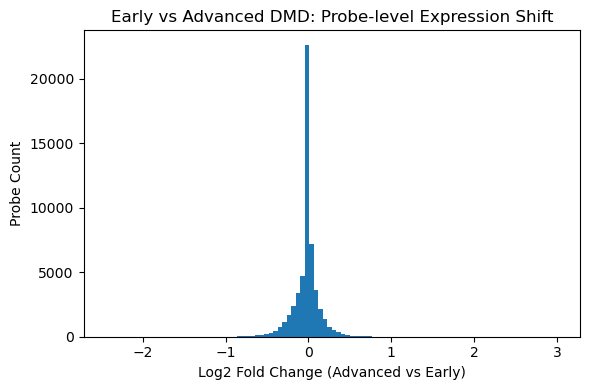

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(de_adv_vs_early["log2FC"], bins=100)
plt.xlabel("Log2 Fold Change (Advanced vs Early)")
plt.ylabel("Probe Count")
plt.title("Early vs Advanced DMD: Probe-level Expression Shift")
plt.tight_layout()
plt.savefig(
    r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\04 - Early_vs_Advanced_DMD_Probe-level_Expression_Shift.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

In [43]:
de_adv_vs_early.to_csv(
     r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\05 - DE_Advanced_vs_Early_ProbeLevel.csv"
)
print("Saved")

Saved


### Early vs Advanced DMD: Probe-Level Expression Shift

To investigate molecular changes associated with disease progression, DMD samples were stratified into **Early** and **Advanced** stages based on age at biopsy, using a left-aligned age threshold to ensure balanced group sizes.

Mean expression values were computed across samples within each group, and **log2 fold change (Advanced vs Early)** was calculated at the **probe level**, leveraging the log-transformed nature of the expression data.

The histogram above shows the **global distribution of probe-level expression changes** across disease progression. The distribution is centered near zero, with extended positive and negative tails, indicating that while many probes remain relatively stable, a subset exhibits substantial progression-associated dysregulation.

This probe-level analysis serves as an initial, unbiased overview of transcriptomic remodeling during DMD progression. In the following steps, probe-level signals are **collapsed to the gene level using Entrez Gene identifiers**, enabling biologically interpretable, systems-level analyses such as gene ontology enrichment.


In [46]:
annot_df = pd.read_csv(
    r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\03 - Probe_to_Gene_Annotation.csv"
)

In [48]:
de_adv_annot = (
    de_adv_vs_early
    .reset_index()
    .rename(columns={"index": "probe_id"})
    .merge(
        annot_df,
        on="probe_id",
        how="left"
    )
)

de_adv_annot.head()

,probe_id,log2FC,gene_symbol,entrez_id
0,1007_s_at,0.171733,DDR1 /// MIR4640,780.0
1,1053_at,-0.231289,RFC2,5982.0
2,117_at,-0.219282,HSPA6,3310.0
3,121_at,0.102328,PAX8,7849.0
4,1255_g_at,0.000000,GUCA1A,2978.0


In [50]:
de_adv_annot.shape

(54675, 4)

In [52]:
de_adv_annot["entrez_id"] = (
    de_adv_annot["entrez_id"]
    .astype(str)
    .str.split(" /// ")
    .str[0]
)

de_adv_annot["entrez_id"] = pd.to_numeric(
    de_adv_annot["entrez_id"],
    errors="coerce"
)

In [54]:
de_adv_annot["entrez_id"].isna().sum()

10541

In [56]:
gene_de_adv = (
    de_adv_annot
    .dropna(subset=["entrez_id"])
    .groupby("entrez_id")
    .agg(
        mean_log2FC=("log2FC", "mean"),
        n_probes=("probe_id", "count")
    )
    .sort_values("mean_log2FC", ascending=False)
)

gene_de_adv.head(10)

,mean_log2FC,n_probes
entrez_id,,
9370.0,2.839304,1
5346.0,2.352755,1
6319.0,2.333063,4
101927268.0,1.662186,1
84649.0,1.578503,2
8839.0,1.566091,1
63924.0,1.483514,1
4257.0,1.412684,5
7857.0,1.410170,1


In [62]:
# Most upregulated with progression
gene_de_adv.head(10)

,mean_log2FC,n_probes
entrez_id,,
9370.0,2.839304,1
5346.0,2.352755,1
6319.0,2.333063,4
101927268.0,1.662186,1
84649.0,1.578503,2
8839.0,1.566091,1
63924.0,1.483514,1
4257.0,1.412684,5
7857.0,1.410170,1


In [64]:
# Most downregulated with progression
gene_de_adv.tail(10)

,mean_log2FC,n_probes
entrez_id,,
221756.0,-1.125005,1
56265.0,-1.196461,1
6447.0,-1.200637,1
5816.0,-1.224595,1
100505664.0,-1.246857,1
347.0,-1.272204,1
3158.0,-1.288472,2
2537.0,-1.541491,1
23630.0,-1.702101,1


In [68]:
gene_de_adv_annot = (
    gene_de_adv
    .reset_index()
    .merge(
        annot_df[["entrez_id", "gene_symbol"]].drop_duplicates(),
        on="entrez_id",
        how="left"
    )
)


In [70]:
# Most upregulated with progression
gene_de_adv_annot.head(10)

,entrez_id,mean_log2FC,n_probes,gene_symbol
0,9370.0,2.839304,1,ADIPOQ
1,5346.0,2.352755,1,PLIN1
2,6319.0,2.333063,4,SCD
3,101927268.0,1.662186,1,LOC101927268 /// LOC102724851
4,84649.0,1.578503,2,DGAT2
5,8839.0,1.566091,1,WISP2
6,63924.0,1.483514,1,CIDEC
7,4257.0,1.412684,5,MGST1
8,7857.0,1.410170,1,SCG2
9,130399.0,1.391437,2,ACVR1C


In [72]:
# Most downregulated with progression
gene_de_adv_annot.tail(10)

,entrez_id,mean_log2FC,n_probes,gene_symbol
21979,221756.0,-1.125005,1,SERPINB9P1
21980,56265.0,-1.196461,1,CPXM1
21981,6447.0,-1.200637,1,SCG5
21982,5816.0,-1.224595,1,PVALB
21983,100505664.0,-1.246857,1,LOC100505664
21984,347.0,-1.272204,1,APOD
21985,3158.0,-1.288472,2,HMGCS2
21986,2537.0,-1.541491,1,IFI6
21987,23630.0,-1.702101,1,KCNE1L
21988,3126.0,-2.048361,2,HLA-DRB4


In [74]:
gene_de_adv_annot.to_csv(
    r"C:\Users\Lenovo\Desktop\UG Stream\Notebooks\05 - Gene_Level_DE_Advanced_vs_Early_Annotated.csv",
    index=False
)
print("Saved")

Saved


### Notebook 05 - Summary and Next Steps
In this notebook, we investigated disease progression–associated transcriptional changes in Duchenne Muscular Dystrophy (DMD) using age at biopsy as a proxy for disease severity. DMD samples were stratified into Early and Advanced stages using a biologically motivated age threshold, while preserving the original early–mid–late staging for complementary analyses.

The following steps were performed:

- Defined an Early vs Advanced disease progression variable without modifying the original staging scheme.
- Verified correct alignment between sample metadata and the expression matrix.
- Computed probe-level differential expression between Advanced and Early DMD samples.
- Visualized global expression shifts using log2 fold-change distributions.
- Collapsed probe-level results to gene-level summaries using Entrez Gene IDs.
- Annotated progression-associated genes with gene symbols.
- Identified the most upregulated and downregulated genes associated with disease progression.
The resulting gene-level patterns are biologically coherent and align with known DMD pathology, including changes related to muscle structure, metabolism, inflammation, and fibrotic remodeling, supporting the validity of the progression framework.

#### Next Steps
In the next notebook, we will:
- Perform pathway and functional enrichment analyses (e.g., GO, KEGG) on progression-associated gene sets.
- Compare progression-driven transcriptional changes with DMD vs Control differential expression results.
- Identify shared and distinct biological processes underlying disease onset versus disease progression.
- Begin organizing results into figures and tables suitable for manuscript preparation.